## Work
1. 試比較 save_best_only 與否的差異
2. 請僅存入將 save_weights_only 設定為 True, 並嘗試 reset ipynb 並將模型與權重重新建回並預測 x_test

In [1]:
import os
from tensorflow import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
# 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preproc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.layers import BatchNormalization

def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

model = build_mlp(input_shape=x_train.shape[1:])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 3072)]            0         
                                                                 
 hidden_layer1 (Dense)       (None, 512)               1573376   
                                                                 
 batch_normalization (BatchN  (None, 512)              2048      
 ormalization)                                                   
                                                                 
 hidden_layer2 (Dense)       (None, 256)               131328    
                                                                 
 batch_normalization_1 (Batc  (None, 256)              1024      
 hNormalization)                                                 
                                                                 
 hidden_layer3 (Dense)       (None, 128)               32896 

In [6]:
# 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 1024
MOMENTUM = 0.95

In [7]:
# 載入 Callbacks
from keras.callbacks import ModelCheckpoint

save_dir = "./checkpoint"
file_name = save_dir + "/D86_HW.h5"

if not os.path.exists(save_dir):
    os.makedirs(save_dir)

## save_best_only = False

In [8]:
model_ckpt = ModelCheckpoint(filepath=file_name, 
                             monitor="val_loss", 
                             save_best_only=False)

optimizer = keras.optimizers.SGD(learning_rate=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

history = model.fit(x_train, y_train, 
                    epochs=EPOCHS, 
                    batch_size=BATCH_SIZE, 
                    validation_data=(x_test, y_test), 
                    shuffle=True,
                    callbacks=[model_ckpt], 
                    verbose=2)

# Collect results
train_loss = model.history.history["loss"]
valid_loss = model.history.history["val_loss"]
train_acc = model.history.history["accuracy"]
valid_acc = model.history.history["val_accuracy"]

Epoch 1/50
49/49 - 6s - loss: 2.2017 - accuracy: 0.2756 - val_loss: 2.0958 - val_accuracy: 0.2359 - 6s/epoch - 127ms/step
Epoch 2/50
49/49 - 4s - loss: 1.7502 - accuracy: 0.3925 - val_loss: 1.9401 - val_accuracy: 0.3149 - 4s/epoch - 80ms/step
Epoch 3/50
49/49 - 4s - loss: 1.6183 - accuracy: 0.4353 - val_loss: 1.8109 - val_accuracy: 0.3693 - 4s/epoch - 84ms/step
Epoch 4/50
49/49 - 4s - loss: 1.5431 - accuracy: 0.4596 - val_loss: 1.7178 - val_accuracy: 0.4035 - 4s/epoch - 92ms/step
Epoch 5/50
49/49 - 4s - loss: 1.4854 - accuracy: 0.4813 - val_loss: 1.6539 - val_accuracy: 0.4214 - 4s/epoch - 87ms/step
Epoch 6/50
49/49 - 4s - loss: 1.4401 - accuracy: 0.4972 - val_loss: 1.5841 - val_accuracy: 0.4443 - 4s/epoch - 80ms/step
Epoch 7/50
49/49 - 4s - loss: 1.3995 - accuracy: 0.5104 - val_loss: 1.5502 - val_accuracy: 0.4528 - 4s/epoch - 86ms/step
Epoch 8/50
49/49 - 4s - loss: 1.3633 - accuracy: 0.5253 - val_loss: 1.5371 - val_accuracy: 0.4574 - 4s/epoch - 78ms/step
Epoch 9/50
49/49 - 5s - loss: 1

In [9]:
model = keras.models.load_model(file_name)
loss_loadback, acc_loadback = model.evaluate(x_test, y_test)

313/313 [==============================] - 1s 3ms/step - loss: 1.7004 - accuracy: 0.4816


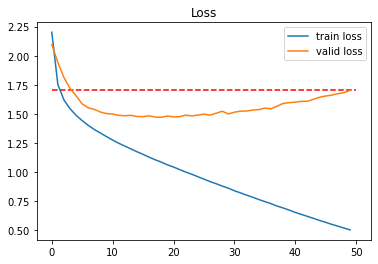

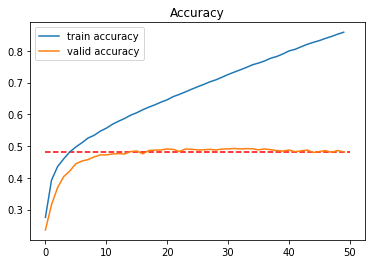

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure()
plt.plot(range(len(train_loss)), train_loss, label="train loss")
plt.plot(range(len(valid_loss)), valid_loss, label="valid loss")
plt.hlines(y=loss_loadback, xmin=0, xmax=len(train_loss), colors='r', linestyles='--')
plt.legend()
plt.title("Loss")
plt.show()

plt.figure()
plt.plot(range(len(train_acc)), train_acc, label="train accuracy")
plt.plot(range(len(valid_acc)), valid_acc, label="valid accuracy")
plt.hlines(y=acc_loadback, xmin=0, xmax=len(train_loss), colors='r', linestyles='--')
plt.legend()
plt.title("Accuracy")
plt.show()

## save_best_only = True, save_weights_only = True

In [11]:
model = build_mlp(input_shape=x_train.shape[1:])

file_name = save_dir + "/D86_HW_weight.h5"
model_ckpt = ModelCheckpoint(filepath=file_name, 
                             monitor="val_loss", 
                             save_best_only=True,
                             save_weights_only=True)

optimizer = keras.optimizers.SGD(learning_rate=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

history = model.fit(x_train, y_train, 
                    epochs=EPOCHS, 
                    batch_size=BATCH_SIZE, 
                    validation_data=(x_test, y_test), 
                    shuffle=True,
                    callbacks=[model_ckpt], 
                    verbose=2)

# Collect results
train_loss = model.history.history["loss"]
valid_loss = model.history.history["val_loss"]
train_acc = model.history.history["accuracy"]
valid_acc = model.history.history["val_accuracy"]

Epoch 1/50
49/49 - 5s - loss: 2.1624 - accuracy: 0.2814 - val_loss: 2.1185 - val_accuracy: 0.2311 - 5s/epoch - 111ms/step
Epoch 2/50
49/49 - 4s - loss: 1.7335 - accuracy: 0.3962 - val_loss: 1.9348 - val_accuracy: 0.3270 - 4s/epoch - 73ms/step
Epoch 3/50
49/49 - 4s - loss: 1.6124 - accuracy: 0.4360 - val_loss: 1.8137 - val_accuracy: 0.3706 - 4s/epoch - 92ms/step
Epoch 4/50
49/49 - 4s - loss: 1.5421 - accuracy: 0.4616 - val_loss: 1.7165 - val_accuracy: 0.3978 - 4s/epoch - 85ms/step
Epoch 5/50
49/49 - 4s - loss: 1.4898 - accuracy: 0.4795 - val_loss: 1.6494 - val_accuracy: 0.4175 - 4s/epoch - 89ms/step
Epoch 6/50
49/49 - 4s - loss: 1.4446 - accuracy: 0.4948 - val_loss: 1.5901 - val_accuracy: 0.4367 - 4s/epoch - 78ms/step
Epoch 7/50
49/49 - 4s - loss: 1.4046 - accuracy: 0.5097 - val_loss: 1.5638 - val_accuracy: 0.4416 - 4s/epoch - 75ms/step
Epoch 8/50
49/49 - 4s - loss: 1.3701 - accuracy: 0.5218 - val_loss: 1.5304 - val_accuracy: 0.4524 - 4s/epoch - 73ms/step
Epoch 9/50
49/49 - 4s - loss: 1

## Reset

In [5]:
file_name = "./checkpoint/D86_HW_weight.h5"
model = keras.models.load_model(file_name)
model.evaluate(x_test, y_test)

ValueError: No model config found in the file at <tensorflow.python.platform.gfile.GFile object at 0x7fd9d7f91190>.